## Data Aggregation for 46K Users
Input files: all files from user_timeline_46K_parsed \
Output files: ../data/user_46K_stats.json

In [1]:
import os
import glob
import json
import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_paths = sorted(glob.glob("../data/user_timeline_46K_parsed/*"), key=lambda x: int(x.split('/')[-1].replace('.json', '')))

In [ ]:
print(file_paths[:5])

print(len(file_paths))

d_data_all = pd.DataFrame([])

for path in tqdm.tqdm(file_paths):
    d_data = pd.read_json(path)
    
    d_agg = d_data.groupby('screen_name').agg({'hashtags': lambda x: sum([len(hashtag) for hashtag in x]),
                                         'user_mentions': lambda x: sum([len(user) for user in x]),
                                         'id_tweet': lambda x: len(x)})
    
    d_agg = d_agg.reset_index()
    
    d_agg['hashtag_per_tweets'] = d_agg.hashtags / d_agg.id_tweet
    d_agg['mention_per_tweets'] = d_agg.user_mentions / d_agg.id_tweet
    
    d_data_all = d_data_all.append(d_agg, ignore_index=True)
    break

d_data_all.to_json("../data/user_46K_stats.json", orient='records')

# Analysis after parsing

Load 46K Users Stats

In [2]:
d_data_all = pd.read_json("../data/supports/user_46K_stats.json")

combine with 7200 users

In [3]:
d_data_7200 = pd.read_json("../data/supports/user_7200_stats.json")

In [4]:
d_data_all = d_data_all.append(d_data_7200, ignore_index=True)

In [5]:
d_data_all.shape

(41761, 6)

In [6]:
d_data_all.drop_duplicates(subset='screen_name', inplace=True)

In [7]:
d_data_all.shape

(41756, 6)

In [8]:
d_data_all

,screen_name,hashtags,user_mentions,id_tweet,hashtag_per_tweets,mention_per_tweets
0,4SinCong,2,430,300,0.006667,1.433333
1,4rdipratama,20,296,300,0.066667,0.986667
2,ABackBone,414,151,300,1.380000,0.503333
3,ARUL77039666,0,13,20,0.000000,0.650000
4,ATAP03167829,5,327,300,0.016667,1.090000
...,...,...,...,...,...,...
41756,zulfikarzat31,35,172,300,0.116667,0.573333
41757,zulhermansyah97,29,377,300,0.096667,1.256667
41758,zulkifli_abdul9,11,212,300,0.036667,0.706667
41759,zulman1,42,304,300,0.140000,1.013333


<AxesSubplot:ylabel='id_tweet'>

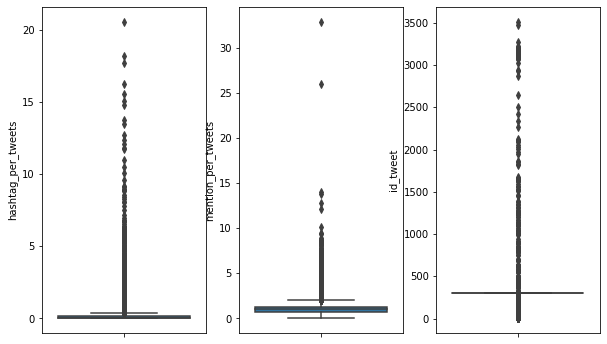

In [9]:
fig, ax = plt.subplots(1,3,figsize=(10,6))
sns.boxplot(y='hashtag_per_tweets', data=d_data_all, ax=ax[0])
sns.boxplot(y='mention_per_tweets', data=d_data_all, ax=ax[1])
sns.boxplot(y='id_tweet', data=d_data_all, ax=ax[2])

### Removing small tweets from accounts

In [10]:
# d_data_all = d_data_all[d_data_all.id_tweet >= 100].copy()

In [11]:
d_data_all.shape

(41756, 6)

In [12]:
d_data_all.describe()

,hashtags,user_mentions,id_tweet,hashtag_per_tweets,mention_per_tweets
count,41756.000000,41756.000000,41756.000000,41756.000000,41756.000000
mean,47.613541,307.373048,283.306591,0.182618,1.058237
std,129.137731,380.529872,117.758722,0.497616,0.677448
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,5.000000,192.000000,300.000000,0.016667,0.733333
50%,15.000000,291.000000,300.000000,0.056037,1.006667
75%,42.000000,372.000000,300.000000,0.160000,1.270000
max,4516.000000,37405.000000,3511.000000,20.523810,32.860000


<AxesSubplot:ylabel='id_tweet'>

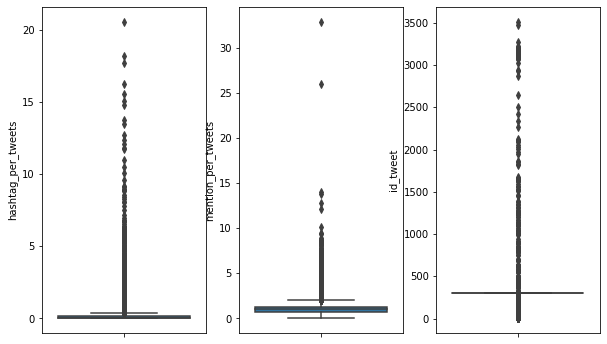

In [13]:
fig, ax = plt.subplots(1,3,figsize=(10,6))
sns.boxplot(y='hashtag_per_tweets', data=d_data_all, ax=ax[0])
sns.boxplot(y='mention_per_tweets', data=d_data_all, ax=ax[1])
sns.boxplot(y='id_tweet', data=d_data_all, ax=ax[2])

#### Set threshold

In [14]:
def get_min_max_thres(series):
    q1 = series.quantile(q=0.25)
    q3 = series.quantile(q=0.75)
    iqr = q3 - q1
    max_thres = q3 + (1.5 * iqr)
    min_thres = q1 - (1.5 * iqr)
    
    return min_thres, max_thres

In [15]:
min_hashtag, max_hashtag = get_min_max_thres(d_data_all.hashtag_per_tweets)

In [16]:
min_mention, max_mention = get_min_max_thres(d_data_all.mention_per_tweets)

In [17]:
d_data_all['is_high_hashtag'] = d_data_all.hashtag_per_tweets.apply(lambda x: 1 if x>= max_hashtag else 0) 

In [18]:
d_data_all['is_high_mention'] = d_data_all.mention_per_tweets.apply(lambda x: 1 if x>= max_mention else 0) 

In [19]:
d_data_all.is_high_hashtag.value_counts()

0    36730
1     5026
Name: is_high_hashtag, dtype: int64

In [20]:
d_data_all.is_high_mention.value_counts()

0    40025
1     1731
Name: is_high_mention, dtype: int64

In [21]:
d_data_all['is_both_high'] = 0

In [22]:
d_data_all.loc[(d_data_all.is_high_hashtag==1) & (d_data_all.is_high_mention==1), 'is_both_high'] = 1

In [23]:
d_data_all.is_both_high.value_counts()

0    41361
1      395
Name: is_both_high, dtype: int64

In [24]:
d_data_all

,screen_name,hashtags,user_mentions,id_tweet,hashtag_per_tweets,mention_per_tweets,is_high_hashtag,is_high_mention,is_both_high
0,4SinCong,2,430,300,0.006667,1.433333,0,0,0
1,4rdipratama,20,296,300,0.066667,0.986667,0,0,0
2,ABackBone,414,151,300,1.380000,0.503333,1,0,0
3,ARUL77039666,0,13,20,0.000000,0.650000,0,0,0
4,ATAP03167829,5,327,300,0.016667,1.090000,0,0,0
...,...,...,...,...,...,...,...,...,...
41756,zulfikarzat31,35,172,300,0.116667,0.573333,0,0,0
41757,zulhermansyah97,29,377,300,0.096667,1.256667,0,0,0
41758,zulkifli_abdul9,11,212,300,0.036667,0.706667,0,0,0
41759,zulman1,42,304,300,0.140000,1.013333,0,0,0


### Cross check with existing manually labeled

In [25]:
d_label = pd.read_csv("../data/account_labeled/project_12_labels_Thu_Oct_15_2020.csv", 
                      names=["id", "text", "label"], skiprows=1)

In [26]:
d_label_updated = pd.read_csv("../data/account_labeled/cross_check_updated.csv")
d_label_updated.rename(columns={"is_buzzer": "label"}, inplace=True)
d_label_updated.label = d_label_updated.label.map({1: "buzzer", 0: "non-buzzer"})
d_label_updated.drop_duplicates('screen_name', inplace=True)

In [28]:
d_autolabel = pd.read_excel("../data/account_labeled/autolabel_of_7200_updated.xlsx", sheet_name=0)

In [29]:
d_label.shape

(3403, 3)

In [30]:
d_label_updated.shape

(982, 12)

In [31]:
d_label.head()

,id,text,label
0,2337,https://twitter.com/fahrisalam __________name:...,buzzer
1,5329,https://twitter.com/Prof_Kupie __________name:...,buzzer
2,6392,"""https://twitter.com/Syam42933824 __________na...",buzzer
3,2131,https://twitter.com/dwiawatie __________name: ...,buzzer
4,5849,https://twitter.com/saaragih __________name: L...,buzzer


In [32]:
d_label = d_label[d_label.label != 'inactive'].copy()

In [33]:
d_label['screen_name'] = d_label.text.apply(lambda x: x.split(' ')[0].split('/')[-1])

In [34]:
d_label = d_label.set_index("screen_name")
d_label_updated = d_label_updated.set_index("screen_name")

In [35]:
d_label.head()

,id,text,label
screen_name,,,
fahrisalam,2337,https://twitter.com/fahrisalam __________name:...,buzzer
Prof_Kupie,5329,https://twitter.com/Prof_Kupie __________name:...,buzzer
Syam42933824,6392,"""https://twitter.com/Syam42933824 __________na...",buzzer
dwiawatie,2131,https://twitter.com/dwiawatie __________name: ...,buzzer
saaragih,5849,https://twitter.com/saaragih __________name: L...,buzzer


In [36]:
d_label_updated[["label"]].head()

,label
screen_name,
02Trus,buzzer
0b4tk3lu4r94,non-buzzer
17Mutawakkil,non-buzzer
2019GNKR,buzzer
2375Lawu,buzzer


In [37]:
d_label.update(d_label_updated[["label"]])

In [38]:
d_label.label.value_counts()

non-buzzer    2329
buzzer         774
Name: label, dtype: int64

In [39]:
d_label = d_label.reset_index()[["screen_name", "label"]]

In [40]:
d_label.label = d_label.label.map({"buzzer": 1, "non-buzzer": 0})

In [41]:
d_autolabel = d_autolabel[["screen_name", "label"]]

In [42]:
d_label = pd.concat((d_label, d_autolabel), axis=0)

In [43]:
d_label.reset_index(drop=True, inplace=True)

In [44]:
d_label = d_label.drop_duplicates(subset='screen_name')

In [45]:
d_label = d_label.set_index('screen_name')

#### Join d_data_all with d_label

In [47]:
d_data_all_annotate = d_data_all.set_index('screen_name').join(d_label[["label"]], on='screen_name', how='left')

In [48]:
d_data_all_annotate.reset_index(inplace=True)

In [49]:
d_data_all_annotate.label.value_counts()

0.0    4978
1.0    1878
Name: label, dtype: int64

In [50]:
d_data_all_annotate.head()

,screen_name,hashtags,user_mentions,id_tweet,hashtag_per_tweets,mention_per_tweets,is_high_hashtag,is_high_mention,is_both_high,label
0,4SinCong,2,430,300,0.006667,1.433333,0,0,0,NaN
1,4rdipratama,20,296,300,0.066667,0.986667,0,0,0,NaN
2,ABackBone,414,151,300,1.380000,0.503333,1,0,0,NaN
3,ARUL77039666,0,13,20,0.000000,0.650000,0,0,0,NaN
4,ATAP03167829,5,327,300,0.016667,1.090000,0,0,0,NaN


#### Dataset for cross check

In [ ]:
d_cross_check = d_data_all_annotate[~d_data_all_annotate.label.isna()].copy()

d_cross_check.reset_index(drop=True, inplace=True)

d_cross_check.rename(columns={'Label': 'is_buzzer'}, inplace=True)

d_cross_check.is_buzzer = d_cross_check.is_buzzer.map({'buzzer': 1, 'non-buzzer': 0})

d_cross_check[d_cross_check.is_high_hashtag != d_cross_check.is_buzzer]

d_cross_check[d_cross_check.is_high_hashtag != d_cross_check.is_buzzer].to_csv("../data/cross_check.csv", index=False)

### Dataset with Autolabeling

In [51]:
d_data_annotate_v2 = d_data_all_annotate[(d_data_all_annotate.screen_name.isin(d_data_7200.screen_name)) & 
                    (d_data_all_annotate.label.isna())]

d_data_annotate_v2.loc[(d_data_annotate_v2.is_high_hashtag == 1) &
                       (d_data_annotate_v2.label.isna()), 'label'] = 'buzzer'

d_data_annotate_v2.loc[(d_data_annotate_v2.is_high_hashtag == 0) &
                       (d_data_annotate_v2.label.isna()), 'label'] = 'non-buzzer'

In [ ]:
d_data_annotate_v2[["screen_name", "label"]].to_csv("../data/account_labeled/autolabel_of_7200.csv", index=False)

#### Modeling

In [53]:
d_data_all_annotate.label.value_counts()

0.0    4978
1.0    1878
Name: label, dtype: int64

In [54]:
d_data_all_annotate[["screen_name", "label"]].to_csv("../data/account_labeled/label_updated.csv", index=False)